In [98]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split,KFold,GridSearchCV
from sklearn.metrics import accuracy_score,classification_report,plot_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [99]:
x = pd.read_csv("independent.csv")
y = pd.read_csv("dependent.csv")
test = pd.read_csv("test.csv")

In [100]:
# combining for the ease of processing
combined = pd.concat([x,test],axis=0)
combined.shape

(74250, 40)

### Exploratory Data Analysis

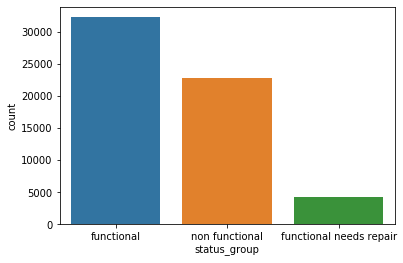

In [101]:
# checking for class imbalances in the response variable
sns.countplot(y['status_group'])
plt.show()

In [102]:
# checking for a summary of the distribution of numerical columns
combined.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,74250.000000,74250.000000,74250.000000,74250.000000,7.425000e+04,74250.000000,74250.000000,74250.000000,74250.000000,74250.000000
mean,37124.500000,318.685704,665.667313,34.074262,-5.701771e+00,0.462330,15.265414,5.629077,180.750828,1298.463650
std,21434.273081,2906.762364,692.761033,6.572519,2.944969e+00,11.537879,17.508907,9.641636,471.086120,952.349375
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18562.250000,0.000000,0.000000,33.086819,-8.525675e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37124.500000,0.000000,364.000000,34.907475,-5.026540e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55686.750000,20.000000,1317.000000,37.181685,-3.325058e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74249.000000,350000.000000,2777.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


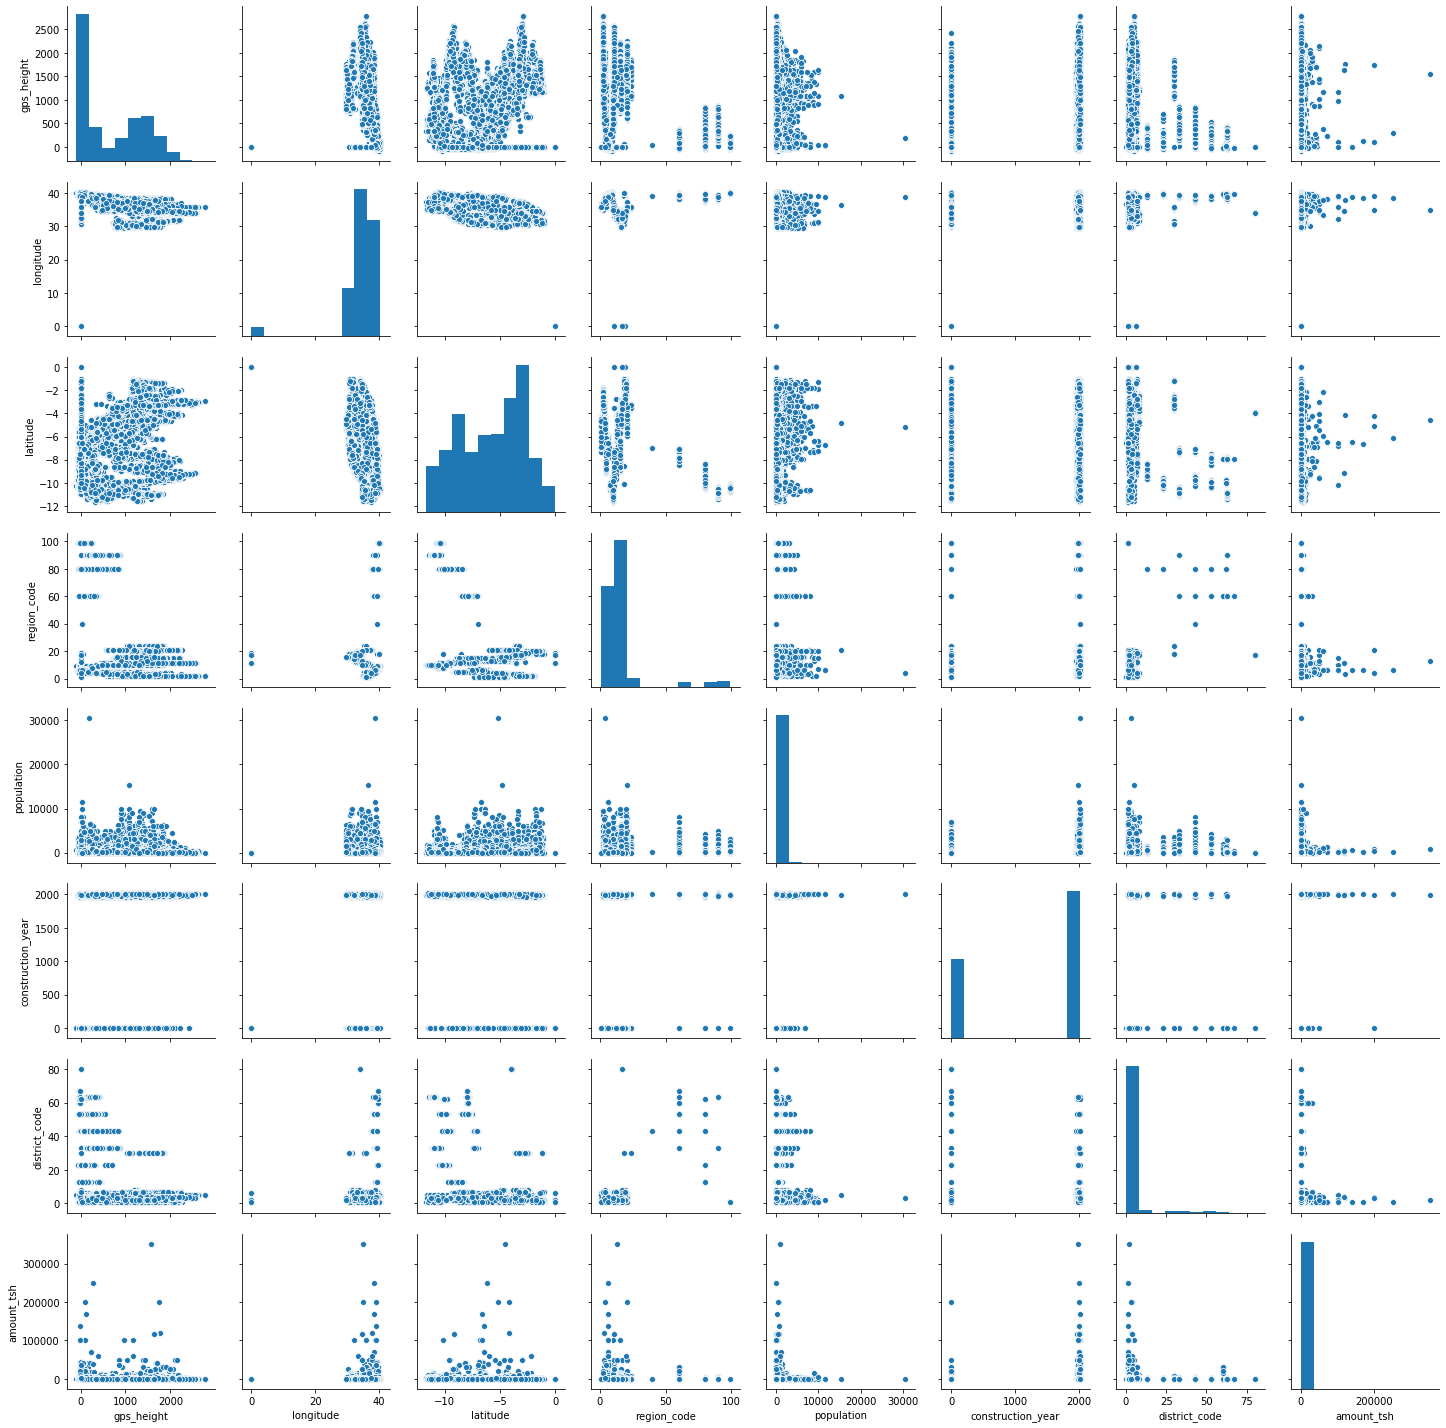

In [103]:
# checking for any correlation between numerical columns
sns.pairplot(combined[['gps_height','longitude','latitude','region_code','population','construction_year','district_code','amount_tsh']])
plt.show()

In [104]:
# checking for missing values in the columns
combined.isna().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    4504
gps_height                   0
installer                 4532
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 470
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            4155
recorded_by                  0
scheme_management         4846
scheme_name              35258
permit                    3793
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

In [105]:
# checking categorical columns and their cardinality
combined.select_dtypes(["object"]).nunique()

date_recorded              369
funder                    2140
installer                 2410
wpt_name                 45684
basin                        9
subvillage               21425
region                      21
lga                        125
ward                      2098
public_meeting               2
recorded_by                  1
scheme_management           12
scheme_name               2868
permit                       2
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_group                6
quantity                     5
quantity_group               5
source                      10
source_type                  7
source_class                 3
waterpoint_type              7
waterpoint_type_group        6
dtype: int64

#### Checking Correlated Categorical Features

###### Inspecting Payment

In [106]:
combined["payment_type"].value_counts()

never pay     31712
per bucket    11266
monthly       10397
unknown       10149
on failure     4842
annually       4570
other          1314
Name: payment_type, dtype: int64

In [107]:
combined["payment"].value_counts()

never pay                31712
pay per bucket           11266
pay monthly              10397
unknown                  10149
pay when scheme fails     4842
pay annually              4570
other                     1314
Name: payment, dtype: int64

###### Inspecting Source

In [108]:
combined["source"].value_counts()

spring                  21216
shallow well            21140
machine dbh             13822
river                   11964
rainwater harvesting     2863
hand dtw                 1108
lake                      950
dam                       840
other                     261
unknown                    86
Name: source, dtype: int64

In [109]:
combined["source_type"].value_counts()

spring                  21216
shallow well            21140
borehole                14930
river/lake              12914
rainwater harvesting     2863
dam                       840
other                     347
Name: source_type, dtype: int64

In [110]:
combined["source_class"].value_counts()

groundwater    57286
surface        16617
unknown          347
Name: source_class, dtype: int64

###### Inspecting Extraction

In [111]:
combined["extraction_type"].value_counts()

gravity                      33263
nira/tanira                  10205
other                         8102
submersible                   5982
swn 80                        4588
mono                          3628
india mark ii                 3029
afridev                       2208
ksb                           1790
other - rope pump              572
other - swn 81                 284
windmill                       152
india mark iii                 135
cemo                           108
other - play pump              101
walimi                          60
climax                          41
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64

In [112]:
combined["extraction_type_group"].value_counts()

gravity            33263
nira/tanira        10205
other               8102
submersible         7772
swn 80              4588
mono                3628
india mark ii       3029
afridev             2208
rope pump            572
other handpump       447
wind-powered         152
other motorpump      149
india mark iii       135
Name: extraction_type_group, dtype: int64

In [113]:
combined["extraction_type_class"].value_counts()

gravity         33263
handpump        20612
other            8102
submersible      7772
motorpump        3777
rope pump         572
wind-powered      152
Name: extraction_type_class, dtype: int64

###### Inspecting Quality

In [114]:
combined["water_quality"].value_counts()

soft                  63505
salty                  6082
unknown                2345
milky                  1005
coloured                623
salty abandoned         423
fluoride                244
fluoride abandoned       23
Name: water_quality, dtype: int64

In [115]:
combined["quality_group"].value_counts()

good        63505
salty        6505
unknown      2345
milky        1005
colored       623
fluoride      267
Name: quality_group, dtype: int64

###### Inspecting Quantity

In [116]:
combined["quantity_group"].value_counts()

enough          41522
insufficient    18896
dry              7782
seasonal         5075
unknown           975
Name: quantity_group, dtype: int64

In [117]:
combined["quantity"].value_counts()

enough          41522
insufficient    18896
dry              7782
seasonal         5075
unknown           975
Name: quantity, dtype: int64

###### Inspecting Water Point

In [118]:
combined["waterpoint_type_group"].value_counts()

communal standpipe    43239
hand pump             21884
other                  8010
improved spring         959
cattle trough           150
dam                       8
Name: waterpoint_type_group, dtype: int64

In [119]:
combined["waterpoint_type"].value_counts()

communal standpipe             35628
hand pump                      21884
other                           8010
communal standpipe multiple     7611
improved spring                  959
cattle trough                    150
dam                                8
Name: waterpoint_type, dtype: int64

###### Inspecting Management

In [120]:
combined["management_group"].value_counts()

user-group    65538
commercial     4591
parastatal     2229
other          1209
unknown         683
Name: management_group, dtype: int64

In [121]:
combined["management"].value_counts()

vwc                 50624
wug                  8108
water board          3688
wua                  3118
private operator     2504
parastatal           2229
water authority      1123
other                1083
company               859
unknown               683
other - school        126
trust                 105
Name: management, dtype: int64

###### Inspecting Other Categorical Columns 

In [122]:
combined["num_private"].value_counts()

0      73299
1         94
6         92
5         60
8         58
       ...  
30         1
669        1
668        1
213        1
62         1
Name: num_private, Length: 68, dtype: int64

In [123]:
combined["wpt_name"].value_counts()

none                      4440
Shuleni                   2183
Zahanati                  1034
Msikitini                  647
Kanisani                   390
                          ... 
Kwa Asajile Mwaigwisya       1
Waumini                      1
Mnondwe                      1
Nyina Enshamba               1
Kwa Mzee Maua                1
Name: wpt_name, Length: 45684, dtype: int64

In [124]:
combined["basin"].value_counts()

Lake Victoria              12871
Pangani                    11143
Rufiji                      9987
Internal                    9642
Lake Tanganyika             8052
Wami / Ruvu                 7577
Lake Nyasa                  6332
Ruvuma / Southern Coast     5587
Lake Rukwa                  3059
Name: basin, dtype: int64

In [125]:
combined["region_code"].value_counts()

11    6608
17    6334
12    5759
3     5494
5     5079
18    4183
19    3824
2     3709
16    3533
10    3306
4     3145
1     2779
13    2536
14    2488
20    2451
15    2242
6     2032
21    1972
80    1536
60    1298
90    1133
7     1020
99     512
9      499
24     402
8      375
40       1
Name: region_code, dtype: int64

In [126]:
combined["district_code"].value_counts()

1     15299
2     13929
3     12521
4     11253
5      5428
6      5108
7      4166
8      1282
30     1256
33     1063
53      921
43      653
13      496
23      360
63      264
62      127
60       76
0        27
80       13
67        8
Name: district_code, dtype: int64

In [127]:
combined["lga"].value_counts()

Njombe          3128
Moshi Rural     1566
Arusha Rural    1521
Bariadi         1485
Rungwe          1381
                ... 
Moshi Urban      103
Kigoma Urban      95
Arusha Urban      82
Lindi Urban       24
Nyamagana          2
Name: lga, Length: 125, dtype: int64

In [128]:
combined["ward"].value_counts()

Igosi        386
Imalinyi     318
Siha Kati    297
Mdandu       292
Nduruma      261
            ... 
Ikweha         1
Kirongo        1
Nyamtinga      1
Mawenzi        1
Sungwisi       1
Name: ward, Length: 2098, dtype: int64

### Data Preprocessing & Feature Engineering

###### Handling Missing Values

In [129]:
# filling missing values of permit & funder
combined['permit'].fillna(method="ffill", inplace=True)
combined['funder'].fillna("Unknown",inplace=True)

# dropping other columns with missing values since they either have high percentage of missing values
# or they have less effect on the predictions
combined.drop(['installer', 'subvillage', 'scheme_management', 'scheme_name','public_meeting'], axis=1, inplace=True)

###### Dropping Categorical Columns which are unique to observations or having less effect on predictions

In [130]:
test_id = combined['id'][59400:] # getting id column of test dataset for output csv file generation before dropping it
combined.drop(['id', 'wpt_name', 'recorded_by', 'num_private', 'ward'], axis=1, inplace=True)

###### Dropping Correlated Categorical Columns Identified through above Inspections

In [131]:
# for example keep source and remove source_type & source_class since they are correlated
combined.drop(['quantity', 'quality_group', 'payment', 'source_type', 'source_class', 'extraction_type_class', 'extraction_type_group', 'waterpoint_type_group', 'management_group', 'region'], axis=1, inplace=True)

###### Imputing 0's & negatives of construction_year, gps_height, population and Create new column year_recorded 

In [132]:
# create new column year_recorded
combined['date_recorded'] = pd.to_datetime(combined['date_recorded'], format="%Y-%m-%d")
combined['year_recorded'] = combined['date_recorded'].dt.year
combined.drop(['date_recorded'], axis=1, inplace=True)
    
# impute 0's of construction_year
contruct_years = combined['construction_year']!=0
years_mean = int(combined[contruct_years].loc[:,'construction_year'].mean())
combined.loc[combined['construction_year']==0,'construction_year'] = years_mean
    
# impute below 0 values of gps_height
gps_heights = combined['gps_height']>0
height_mean = combined[gps_heights].loc[:,'gps_height'].mean()
combined.loc[combined['gps_height']<=0,'gps_height'] = height_mean

# impute 0's of population
populations = combined['population']!=0
pops_median = int(combined[populations].loc[:,'population'].median())
combined.loc[combined['population']==0,'population'] = pops_median

###### Feature Scaling

In [133]:
# scaling down the numerical features which have values varying in high ranges
num_features = ['gps_height','longitude','latitude','population','amount_tsh']

standardScaler = StandardScaler()

combined[num_features] = standardScaler.fit_transform(combined[num_features])

###### Encoding High Cardinality (more than 10 categories) Categorical Features using Label Encoding 

In [134]:
lben=LabelEncoder()
combined[['permit','funder','region_code','district_code','source','extraction_type','management','construction_year','year_recorded','lga']] = combined[['permit','funder','region_code','district_code','source','extraction_type','management','construction_year','year_recorded','lga']].apply(lambda col: lben.fit_transform(col))

###### Encoding Categorical Features with Low Cardinality (less than 10 categories) using Dummy Variables (One-Hot Encoding)

In [135]:
features = ['basin','payment_type','water_quality','quantity_group','waterpoint_type']

# Creating Dummies for the ctegorical features
combined_dum = pd.get_dummies(combined[features])

# Dummy Trapping
combined_dum.drop(['basin_Internal','payment_type_annually','water_quality_coloured','quantity_group_dry','waterpoint_type_cattle trough'],axis=1,inplace=True)

# Dropping Original Columns
combined.drop(features,axis=1,inplace=True)

# Combining one-hot encoded columns with other columns
combined_new = pd.concat([combined,combined_dum],axis=1)

###### Label Encoding Response Variable 

In [136]:
le = LabelEncoder()
y_new = le.fit_transform(y['status_group'])

### Model Training & Testing 

In [137]:
# splitting back again
x_new = combined_new.iloc[:59400,:]
test_new = combined_new.iloc[59400:,:]

In [138]:
x_train, x_test, y_train, y_test = train_test_split(x_new,y_new,test_size=0.2,random_state=1)

###### Hyperparameter Optimization 

In [ ]:
tuneModel=RandomForestClassifier()
params={"random_state":[0,1,10,20], "n_estimators":[100,150,200,250,300,500],"max_depth":[15,20,25,30,40,45]}
cval=KFold(n_splits=5)
gsearch=GridSearchCV(tuneModel,params,cv=cval)
grid_results=gsearch.fit(x_train,y_train)
grid_results.best_params_

###### Training 

In [139]:
model = RandomForestClassifier(n_estimators=500, max_depth=20, random_state=1)
model.fit(x_train,y_train)

RandomForestClassifier(max_depth=20, n_estimators=500, random_state=1)

In [140]:
predictions = model.predict(x_test)

###### Checking Results 

In [141]:
accuracy_score(y_test, predictions)

0.8133838383838384

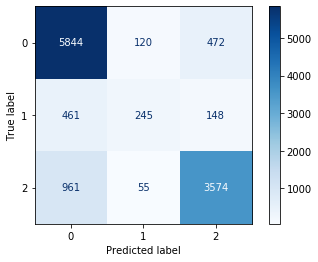

In [142]:
plot_confusion_matrix(model,x_test,y_test,cmap=plt.cm.Blues)
plt.show()

In [143]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.80      0.91      0.85      6436
           1       0.58      0.29      0.38       854
           2       0.85      0.78      0.81      4590

    accuracy                           0.81     11880
   macro avg       0.75      0.66      0.68     11880
weighted avg       0.81      0.81      0.80     11880



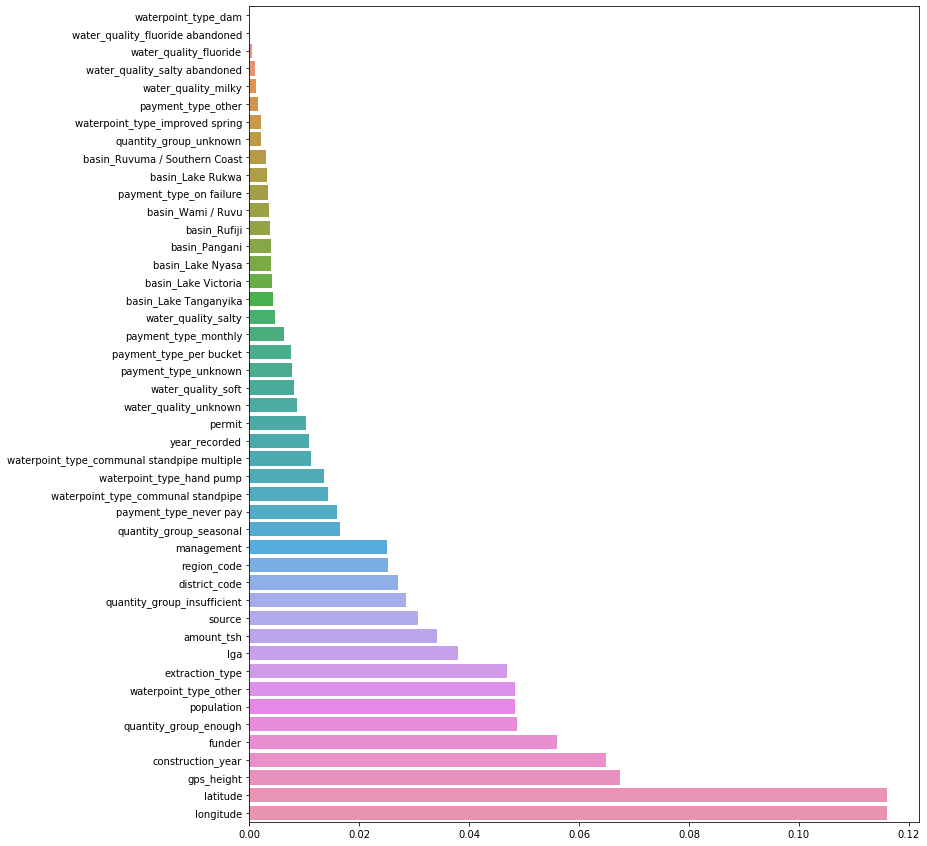

In [144]:
plt.figure(figsize=(12,15))
idx=np.argsort(model.feature_importances_)
sns.barplot(x=model.feature_importances_[idx],y=x_new.columns[idx])
plt.show()

###### Predictions for Submission 

In [145]:
test_preds = model.predict(test_new)

submissions = ["functional" if i==0 else "functional needs repair" if i==1 else "non functional" for i in test_preds]

In [146]:
output = pd.DataFrame({'id': test_id, 'status_group': submissions})
output.to_csv('./submissions/my_submission.csv', index=False)